In [74]:
import numpy as np


class InputSet:
    def __init__(self, height, width, ):
        self.event_bitrate = None
        self.adder_features = np.zeros((height, width), dtype=bool)
        self.adder_time = None
        self.cv_features = np.zeros((height, width), dtype=bool)
        self.cv_time = None
        self.psnr = None
        self.mse = None
        self.ssim = None

    def total_adder(self):
        return np.sum(self.adder_features.astype(int))

    def total_cv(self):
        return np.sum(self.cv_features.astype(int))

In [75]:
def process_entry(entry, input_sets):
    if 's' in entry:
        if "OpenCV" in entry['s']:
            input_sets[-1].cv_features[entry['y'], entry['x']] = True
        elif "ADDER" in entry['s']:
            input_sets[-1].adder_features[entry['y'], entry['x']] = True
        else:
            raise Exception("Malformed entry")
    elif 'psnr' in entry:
        input_sets[-1].psnr = entry['psnr']
        input_sets[-1].mse = entry['mse']
        input_sets[-1].ssim = entry['ssim']


In [76]:
import pickle

objects = []
with (open("/home/andrew/Code/adder-codec-rs/features_19_10_2023_16_56_44.log", "rb")) as openfile:
    # Read the dimensions
    dims = openfile.readline().decode('UTF-8')
    print(dims)
    width = int(dims.split('x')[0])
    height = int(dims.split('x')[1])
    channels = int(dims.split('x')[2])
    #
    dbg_lines = 0
    #
    input_interval_idx = 0
    #
    input_sets = [InputSet(height, width)]

    while True:
        try:
            entry = pickle.load(openfile)
            if type(entry) == str and "ADDER FAST:" in entry:
                # The start of a new interval
                time = entry.split(': ')[1]
                input_sets[-1].adder_time = int(time)
                continue
            elif type(entry) == str and "bps:" in entry:
                # The bitrate
                # The end of the interval
                bitrate = float(entry.split(': ')[1]) / 1024.0 / 1024.0
                input_sets[-1].event_bitrate = bitrate

                input_sets += [InputSet(height, width)]
                input_interval_idx += 1
                continue
            elif type(entry) == str and "OpenCV FAST:" in entry:
                time = entry.split(': ')[1]
                input_sets[-1].cv_time = int(time)

            elif type(entry) == str and "META:" in entry:
                print(entry)
            else:
                process_entry(entry, input_sets)

                # print(entry)
                dbg_lines += 1
                # if dbg_lines == 100000:
                #     break
        except pickle.UnpicklingError:
            line = openfile.readline().decode('UTF-8')
            if "Ticks per second" in line:
                tps = int(line.split(': ')[2])
            elif "ticks per source interval" in line:
                tpf = int(line.split(': ')[2])
            print(line)
        except EOFError:
            break



960x540x1

META: Ticks per second: 7642

META: Reference ticks per source interval: 255

META: Δt_max: 76500

META: CRF: 7

META: c_thresh_baseline: 5

META: c_thresh_max: 20

META: c_increase_velocity: 3


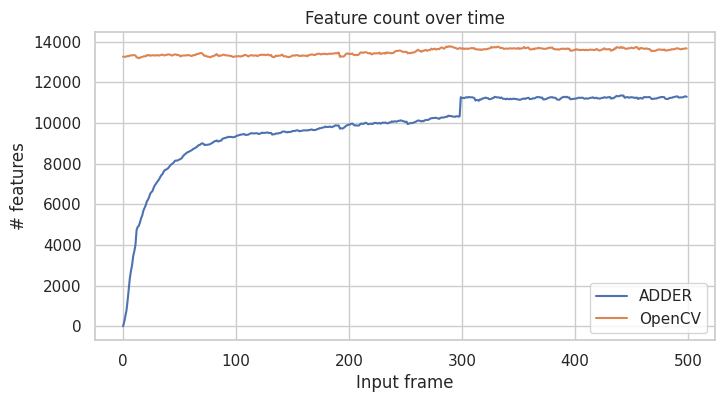

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import mpld3

adder_feature_count = [obj.total_adder() for obj in input_sets]
cv_feature_count = [obj.total_cv() for obj in input_sets]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))

sns.lineplot(x=range(len(input_sets) - 1), y=adder_feature_count[:-1], marker=None, label="ADDER")
sns.lineplot(x=range(len(input_sets) - 1), y=cv_feature_count[:-1], marker=None, label="OpenCV")
plt.ylabel("# features")
plt.xlabel("Input frame")
plt.title("Feature count over time")

plt.show()
# interactive_plot = mpld3.display()
# interactive_plot

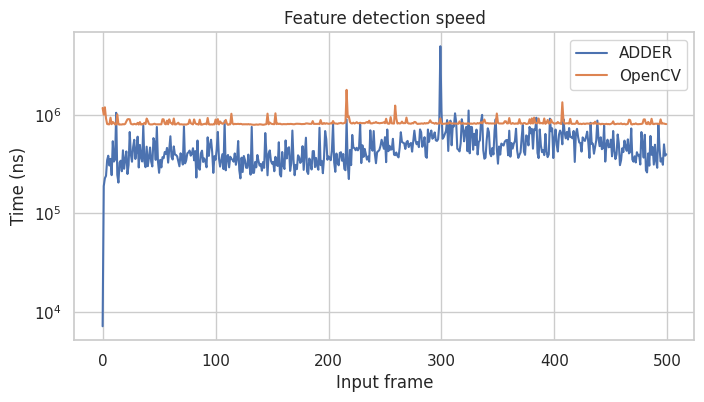

OpenCV mean: 829938.306   Median: 813888.0
ADDER mean: 475878.054 (-42.7%)   Median: 427632.0


In [78]:
adder_times = [obj.adder_time for obj in input_sets]
cv_times = [obj.cv_time for obj in input_sets]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))

sns.lineplot(x=range(len(input_sets)), y=adder_times, marker=None, label="ADDER")
sns.lineplot(x=range(len(input_sets)), y=cv_times, marker=None, label="OpenCV")
plt.ylabel("Time (ns)")
plt.xlabel("Input frame")
plt.yscale('log')
plt.title("Feature detection speed")

plt.show()
# interactive_plot = mpld3.display()
# interactive_plot


cv_mean = np.mean(np.array(cv_times[:-1]))
adder_mean = np.mean(np.array(adder_times[:-1]))
percent_change = (adder_mean / cv_mean) - 1
print('OpenCV mean:', cv_mean, '  Median:', np.median(np.array(cv_times[:-1])))
print('ADDER mean:', adder_mean, "({:.1f}%)".format(percent_change * 100), '  Median:',
      np.median(np.array(adder_times[:-1])))


# Bitrate over time

118.52826286764706


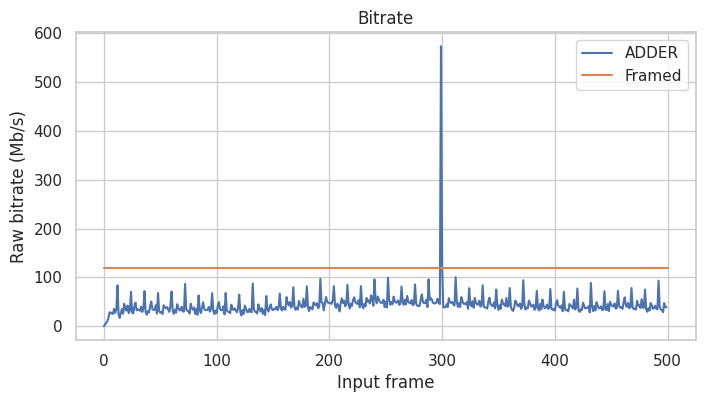

[0.0, 16.521934419519763, 28.54761442296645, 54.55798321892233, 68.12905776079964, 100.96509058335249, 103.52085625143613, 80.90788610121784, 84.6118943158318, 142.84096123190486, 73.71387903550092, 112.09769305060891, 259.4369664809283, 55.29466929716222, 47.53682986988741, 70.19095566693474, 89.67609665814568, 65.9951374727137, 156.66102743709789, 95.91529271742877, 76.51657858455881, 141.16798418830422, 70.33500043083639, 89.94978170955883, 244.47894664091223, 52.35409833122702, 65.4518829345703, 131.28239781996783, 134.33820459702434, 91.55690971823299, 88.26857353659237, 85.48850959329044, 91.36142039579504, 154.20815088608688, 68.53444088206571, 82.48208959242878, 210.8239164464614, 62.94138847799862, 56.623996689740345, 111.70259884105009, 62.09358215332031, 111.44743383071003, 154.14024406881893, 88.22741788976333, 88.21301341337316, 96.46677838493795, 116.11654196346508, 68.78960589240579, 234.54191571403953, 60.03991537655101, 48.88261952119716, 86.68613891601562, 65.68029677

In [79]:
adder_bitrates = [obj.event_bitrate for obj in input_sets]

source_raw_Mbps = (width * height * channels * (tps / tpf) * 8.0) / 1024.0 / 1024.0
print(source_raw_Mbps)
framed_bitrates = [source_raw_Mbps for obj in input_sets]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))

sns.lineplot(x=range(len(input_sets)), y=adder_bitrates, marker=None, label="ADDER")
sns.lineplot(x=range(len(input_sets)), y=framed_bitrates, marker=None, label="Framed")
plt.ylabel("Raw bitrate (Mb/s)")
plt.xlabel("Input frame")
# plt.yscale('log')
plt.title("Bitrate")

plt.show()
print(bitrates)
# interactive_plot = mpld3.display()
# interactive_plot


# cv_mean = np.mean(np.array(cv_times[:-1]))
# adder_mean = np.mean(np.array(adder_times[:-1]))
# percent_change = (adder_mean / cv_mean) - 1
# print('OpenCV mean:', cv_mean, '  Median:', np.median(np.array(cv_times[:-1])))
# print('ADDER mean:', adder_mean, "({:.1f}%)".format(percent_change * 100), '  Median:',
#       np.median(np.array(adder_times[:-1])))
